In [5]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 3)

from util import nn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load HPC data
data_folder = '/app/data'
hpc = pd.read_csv(data_folder+ '/hpc.csv', parse_dates=['timestamp'])

# Identify input columns
hpc_in = hpc.columns[1:-1]

# Standardization
tr_end, val_end = 3000, 4500
hpcs = hpc.copy()
tmp = hpcs.iloc[:tr_end]
hpcs[hpc_in] = (hpcs[hpc_in] - tmp[hpc_in].mean()) / tmp[hpc_in].std()

# Training, validation, and test set
trdata = hpcs.iloc[:tr_end]
valdata = hpcs.iloc[tr_end:val_end]
tsdata = hpcs.iloc[val_end:]

# Anomaly labels
hpc_labels = pd.Series(index=hpc.index, data=(hpc['anomaly'] != 0), dtype=int)

# Cost model
c_alarm, c_missed, tolerance = 1, 5, 12
cmodel =  nn.HPCMetrics(c_alarm, c_missed, tolerance)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Density Estimation with Neural Models

## Density Estimation vs Autoencoders

**Anomaly detection can be formulated as density estimation**

* This is probably _the cleanest formulation_ for the problem
* ...And usually leads to good results

**KDE as an estimation technique**

* ...Works reasonably well for low-dimensional data
* ...Becomes _slower and more data hungry_ for higher-dimensional data

**Autoencoders overcome some of these limitations**

* They are _faster and less data hungry_ for high-dimensional data
* They can provide _additional insight_ in the anomalies
* ...But they tend to be _worse_ than D.E. in terms of _pure detection power_

**Let's try to understand why this may be the case...**

## Density Estimation vs Autoencoders

**Anomaly Detection based on D.E. checks whether:**

$$
- \log f({\bf x}, \lambda) \geq \theta
$$

* Where $\bf x$ is the input vector, $f$ the density estimator, and $\lambda$ its parameter vector
* $\theta$ is the anomaly detection threshold

**Anomaly Detection based on autoencoders usually relies on:**

$$
\|g({\bf x}, \lambda) - {\bf x}\|_2^2 \geq \theta^\prime
$$

* Where $g$ is the autoencoder, with parameter vector $\lambda$
* $\theta^\prime$ is again a suitably-chosen detection threshold

## Density Estimation vs Autoencoders

**The detection condition for autoencoders admits a probabilistic interpretation**

Like we did for linear regression, we can rewrite:

$$
\|g({\bf x}, \lambda) - {\bf x}\|_2^2 \longrightarrow
\sum_{j=1}^m (g_j({\bf x}, \lambda) - x_j)^2 \longrightarrow
\log \prod_{j=1}^m \exp\left((g_j({\bf x}, \lambda) - x_j)^2\right)
$$

From which, with an _affine transformation_, for some fixed $\sigma$ we get:

$$
\log \frac{1}{\sigma\sqrt{2\pi}} + \frac{1}{\sigma^2} \log \prod_{j=1}^m \exp \left((g_j({\bf x}, \lambda) - x_j)^2\right) \quad \longrightarrow\\
\longrightarrow\quad \log \prod_{j=1}^m \frac{1}{\sigma\sqrt{2\pi}} \exp \left(\left(\frac{g_j({\bf x}, \lambda) - x_j}{\sigma}\right)^2\right) 
$$

* The transformation preserves all the optimal points

## Density Estimation vs Autoencoders

**Therefore, optimizing the MSE is equivalent to optimizing**

$$
-\log \prod_{j=1}^m \varphi (x_j \mid g_j({\bf x}, \lambda), \sigma)
$$

* I.e. the log likelihood (estimated conditional probability of the data)...
* ...Assuming that the prediction for each $x_i$ is _independent and normally distributed_
* ...with _mean_ equal to the predictions $g_j({\bf x}, \lambda)$ and fixed _standard deviation_ $\sigma$

**This is similar to what we observed for Linear Regression**

* In LR, we assume normality, independence and fixed variance _on the samples_
* Here, we do it _also on the features_

## Density Estimation vs Autoencoders

**The bottomline**

* Even with autoencoders, at training time we _solve a density estimation problem_
* ...But we do it _with some limiting assumptions_

> **This is why D.E.-based anomaly detection _tends to work better_**

**So we have**

* Either a density estimator with issues on high-dimensional data (KDE)
* ...Or a worse D.E. with good support for high-dimensional data  (autoencoders)


> **Can we get the best of both worlds?**

## Flow Models

**Ideally, we wish _a neural approach for density estimation_**

There are only a handful of approaches, often referred to as _flow models_:

* [Normalizing Flows](https://arxiv.org/abs/1505.05770)
* [Real Non-Volume Preserving transformations (Real NVP)](https://arxiv.org/abs/1605.08803)
* [Generative Flow with 1x1 convolutions (Glow)](https://arxiv.org/abs/1807.03039)

**These are all (fairly) advanced and recent approaches**

* Main idea: transforming _a simple (and known) probability distribution_...
* ..._Into a complex (and unknown) distribution_ that matches that of the available data

As many ML models, they are trained for maximum likelihood

* I.e. to maximize the estimated probability of the available data

## Flow Models

**All flow models rely on the _change of variable formula_**

* Let $x$ be a random variable representing the source of our data
* Let $p_x(x)$ be its (unknown) density function
* Let $z$ be a random _latent variable_ with known distribution $p_z$
* Let $f$ be a _bijective_ (i.e. invertible) transformation

Then, the change of variable formula states that:

$$
p_x(x) = p_z(f(x)) \left| \det \left(\frac{\partial f(x)}{\partial x^T} \right)\right|
$$

* Where $\det$ is the determinant and $\partial f / \partial x^T$ is the Jacobian of $f$

**The formula links the two distributions via _the flow model $f$_**

## Flow  Models

**Let's consider how we can use the formula**

$$
p_x(x) = p_z(f(x)) \left| \det \left(\frac{\partial f(x)}{\partial x^T} \right)\right|
$$

* Given _an example $x$_ (e.g. from our dataset)
* We _compute the mapping $f(x)$_, i.e. the corresponding value for the latent variable $z$
* ...Plus the _determinant of the Jacobian_ $\partial f / \partial x^T$ in $x$
* Then we can use the formula to compute the _probability of the example_

**The challenge is defining the transformation $f$ (i.e. the mapping)**

* It must be _invertible_ (for the formula to hold)
* It must be _non-linear_ (to handle any distribution)
* It should allow for an _easy computation of the determinant_

## Real NVP

**We will use [Real Non-Volume Preserving transformations](https://arxiv.org/abs/1605.08803) as an example**

Real NVPs are _a type of neural network_

* _Input:_ a vector $x$ representing an example
* _Output:_ a vector $z$ of values for the latent variable
* _Key property:_ $z$ should have a chosen probability distribution
* ...Typically: standard Normal distribution for each $z_i$:

$$
z \sim \mathcal{N}({\bf 0}, I)
$$

In other words

* $z$ follows a multivariate distribution
* ...But the covariance matrix is diagonal, i.e. each component is independent

## Real NVP

**A Real NVP architecture consists of a stack of _affine coupling layers_**

Each layer treats its input $x$ as split into two components, i.e. $x = (x^1, x^2)$

* One component is _passed forward_ as it is
* The second is processed via an _affine transformation_

$$\begin{align}
y^1 &= x^1 \\
y^2 &= e^{s(x^1)} \odot x^2 + t(x^1)
\end{align}$$

**The affine transformation is parameterized with two functions:**

* $x^2$ is _scaled_ using $e^{s(x^1)}$, $x^2$ is _translated_ using $t(x^1)$
* $\odot$ is the element-wise product (Hadamard product)

Since we have functions rather than fixed vectors, _the transformation is non-linear_

## Real NVP - Affine Coupling Layers

**Visually, each layer has the following _compute graph:_**

<center><img src="assets/RealNVP-fwd.png" width="250px"/></center>

* We are using part of the input (i.e. $x^1$)...
* ...To transform the remaining part (i.e. $x^2$)

**Both $s$ and $t$ are usually implemented as Multilayer Perceptrons**

* I.e. pretend there are a few fully connected layers when you see $s$ and $t$

## Real NVP - Affine Coupling Layers

**Each affine coupling layer is _easy to invert_**

<center><img src="assets/RealNVP-bwd.png" width="250px"/></center>

Since part of the input (i.e. $x^1$) has been passed forward unchanged, we have that:

$$\begin{align}
x^1 &= y^1 \\
x^2 &= (y^2 - t(y^1)) \oslash e^{s(y^1)}
\end{align}$$

* $\oslash$ is the element-wise division

## Real NVP - Affine Coupling Layers

**The _determinant_ of each layer is easy to compute**

The Jacobian of the transformation is:

$$
\frac{\partial y}{\partial x^T} = \left(\begin{array}{cc}
I & 0 \\
\frac{\partial t(x^1)}{\partial x^T} & \text{diag}(e^{s(x^1)})
\end{array}\right)
$$

The most (only, actually) important thing is that _the matrix is triangular:_

* ...Hence, its determinant is the product of the terms on the main diagonal:

$$
\det\left(\frac{\partial y}{\partial x^T}\right) = \prod_{j \in I_{x_1}} e^{s(x^1_i)} = \exp \left( \sum_{j \in I_{x_1}} s(x^1_i) \right)
$$

## Real NVP - Considerations

**Overall, we have a transformation that:**

* ...Is _non-linear_, and can be made arbitrarily _deep_
* ...Is _Invertible_ (so as to allow application of the change of variable formula)
* ...Is well suited for _determinant computation_

**Depth and non-linearity are very important:**

* The whole approach works _only if_ we can construct a mapping between $x$ and $z$...
* ...I.e. if we can transform one probability distribution into the other

A poor mapping will lead to poor estimates



## Real NVP - Considerations

**At training time we maximize the log likelihood...**

...Hence we care about _log probabilities_:

$$
\log p_x(x) = \log p_z(f(x)) +\log\, \left| \det \left(\frac{\partial f(x)}{\partial x^T} \right)\right|
$$

* If we choose a Normal distribution for $z$, the log _cancels all exponentials in the formula_
* I.e. the one in the Normal PDF and the one in the determinant computation

**In general, we want to make sure that all variables are transformed**

* We need to be careful to define the $x^1, x^2$ components on different layers...
* ...So that no variable is passed forward unchanged along the whole network

A simple approach: _alternate the roles_ (i.e. swap the role of $x^1, x^2$ at every layer)

## Real NVP as Generative Models

**Since Real NVPs are invertible, they can be used as _generative models_**

Formally, they can _sample_ from the distribution they have learned

* We just need to sample from $p_z$, i.e. on the latent space
  - ...And this is easy since the distribution is simple an known
* Then we go through the whole architecture _backwards_
  - ...Using the inverted version of the affine coupling layers

**In fact, generating data is often their _primary purpose_**

They can (or could) be used for:

* Super resolution
* Procedural content generation
* Data augmentation (relevant in an industrial context)

Recent versions allow for [data generation with controlled attributes](https://openai.com/blog/glow/)

# Implementing Real NVPs

## Implementing Real NVPs

**We will now see how to implement Real NVPs**

The basis from our code comes from the [official keras documentation](https://keras.io/examples/generative/real_nvp/)

* It will rely partially on low-level APIs of keras

We start by importing several packages:

```python
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.datasets import make_moons
```

* `tensorflow_probability` is a tensorflow extension for probabilistic computations
* ...And allows for easy manipulation of probability distributions

## Affine Coupling Layer

**Then we define a function to build each _affine coupling layer_:**

```python
def coupling(input_shape, nunits=64, nhidden=2, reg=0.01):
    assert(nhidden >= 0)    
    x = keras.layers.Input(shape=input_shape)
    # Build the layers for the t transformation (translation)
    t = x
    for i in range(nhidden):
        t = Dense(nunits, activation="relu", kernel_regularizer=l2(reg))(t)
    t = Dense(input_shape, activation="linear", kernel_regularizer=l2(reg))(t)
    # Build the layers for the s transformation (scale)
    s = x
    for i in range(nhidden):
        s = Dense(nunits, activation="relu", kernel_regularizer=l2(reg))(s)
    s = Dense(input_shape, activation="tanh", kernel_regularizer=l2(reg))(s)
    # Return the layers, wrapped in a keras Model object
    return keras.Model(inputs=x, outputs=[s, t])
```

## Affine Coupling Layer

**This part of the code builds _the translation (i.e. $t$) function:_**

```python
def coupling(input_shape, nunits=64, nhidden=2, reg=0.01):
    ...   
    x = keras.layers.Input(shape=input_shape)
    t = x
    for i in range(nhidden):
        t = Dense(nunits, activation="relu", kernel_regularizer=l2(reg))(t)
    t = Dense(input_shape, activation="linear", kernel_regularizer=l2(reg))(t)
    ...
```

* It's _just a Multi-Layer Perceptron_ built using the functional API
* The output represents an offset, hence the "linear" activation function in the last layer

## Affine Coupling Layer

**This part of the code builds _the translation (i.e. $t$) function:_**

```python
def coupling(input_shape, nunits=64, nhidden=2, reg=0.01):
    ...   
    x = keras.layers.Input(shape=input_shape)
    t = x
    for i in range(nhidden):
        t = Dense(nunits, activation="relu", kernel_regularizer=l2(reg))(t)
    t = Dense(input_shape, activation="linear", kernel_regularizer=l2(reg))(t)
    ...
```

* The output and input have the same shape, but $x^1$ and $x^2$ may have _different size_
* This will be resolved by _masking_ some of the output of the affine layer
* ...The masked portions _will have no effect_, with effectively the same result
* The main drawback is higher memory consumption (and computational cost)

## Affine Coupling Layer

**This part of the code builds _the scaling (i.e. $s$) function:_**

```python
def coupling(input_shape, nunits=64, nhidden=2, reg=0.01):
    ...   
    x = keras.layers.Input(shape=input_shape)
    ...
    s = x
    for i in range(nhidden):
        s = Dense(nunits, activation="relu", kernel_regularizer=l2(reg))(s)
    s = Dense(input_shape, activation="tanh", kernel_regularizer=l2(reg))(s)
    ...
```

* Another MLP, with a bipolar sigmoid ("tanh") activation function in the output layer
* Using "tanh" limits the amount of scaling per affine coupling layer
* ...Which in turn makes training more numerically stable
* For the same reason, we use L2 regularizers on the MPL weights

## RNVP Model

**Then, we define a Real NVP architecture by subclassing keras.model**

```python
class RealNVP(keras.Model):
    def __init__(self, input_shape, num_coupling, units_coupling=32, depth_coupling=0,
            reg_coupling=0.01): ...
    @property
    def metrics(self): ...
    def call(self, x, training=True): ...
    def log_loss(self, x): ...
    def score_samples(self, x): ...
    def train_step(self, data): ...
    def test_step(self, data): ...
```

* We will now discuss _the most important methods_
* Sometimes with a few  simplifications (for sake of clarity)

## RNVP Model

**The `__init__` method (constructor) initializes the internal fields**

```python
    def __init__(self, input_shape, num_coupling, units_coupling=32, depth_coupling=0,
            reg_coupling=0.01):
        super(RealNVP, self).__init__()
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=np.zeros(input_shape, dtype=np.float32),
            scale_diag=np.ones(input_shape, dtype=np.float32)
        )
        half_n = int(np.ceil(input_shape/2))
        m1 = ([0, 1] * half_n)[:input_shape]
        m2 = ([1, 0] * half_n)[:input_shape]
        self.masks = np.array([m1, m2] * (num_coupling // 2), dtype=np.float32)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [coupling(input_shape, units_coupling, depth_coupling, reg_coupling)
                            for i in range(num_coupling)]
```

## RNVP Model

**The `__init__` method (constructor) initializes the internal fields**

```python
    def __init__(self, input_shape, num_coupling, units_coupling=32, depth_coupling=0,
            reg_coupling=0.01):
        ...
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=np.zeros(input_shape, dtype=np.float32),
            scale_diag=np.ones(input_shape, dtype=np.float32)
        )
        ...
```

Here we build a `tfp` object to handle the known distribution

* As it is customary, we chosen a Multivariate Normal distribution
* ...With independent components, zero mean, and unary standard deviation

## RNVP Model

**The `__init__` method (constructor) initializes the internal fields**

```python
    def __init__(self, input_shape, num_coupling, units_coupling=32, depth_coupling=0,
            reg_coupling=0.01):
        ...
        half_n = int(np.ceil(input_shape/2))
        m1 = ([0, 1] * half_n)[:input_shape]
        m2 = ([1, 0] * half_n)[:input_shape]
        self.masks = np.array([m1, m2] * (num_coupling // 2), dtype=np.float32)
        ...
```

Here we build the masks to discriminate the $x_1$ and $x_2$ components at each layer

* As in the original RNVP paper, we use an _alternating checkboard pattern_
  - I.e. we take even indexes at one layer, and odd indexes at the next layer
* ...So that all variables are transformed, if we have at least 2 affine coupling layers

## RNVP Model

**The `__init__` method (constructor) initializes the internal fields**

```python
    def __init__(self, input_shape, num_coupling, units_coupling=32, depth_coupling=0,
            reg_coupling=0.01):
        ...
        self.layers_list = [coupling(input_shape, units_coupling, depth_coupling, reg_coupling)
                            for i in range(num_coupling)]
```

Finally, here we build the model layers

* Each one consists in an affine coupling
* ...And contains in turn two Multi Layer Perceptrons
* Recall that we need at least 2 affine couplings to transform all variables

## RNVP Model

**The `call` method handles the transformation, in both directions**

```python
def call(self, x, training=True):
    log_det_inv, direction = 0, 1
    if training: direction = -1
    for i in range(self.num_coupling)[::direction]:
        x_masked = x * self.masks[i]
        reversed_mask = 1 - self.masks[i]
        s, t = self.layers_list[i](x_masked)
        s, t = s*reversed_mask, t*reversed_mask
        gate = (direction - 1) / 2
        x = reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) \
            + x_masked
        log_det_inv += gate * tf.reduce_sum(s, axis=1)
    return x, log_det_inv
```



## RNVP Model

**The `call` method handles the transformation, in both directions**

```python
def call(self, x, training=True):
    log_det_inv, direction = 0, 1
    if training: direction = -1
    for i in range(self.num_coupling)[::direction]:
    ...
```

The `direction` variable controls the direction of the transformation

* By default, this implementation transforms $z$ into $x$
  - I.e. it works _backwards_, compared to our theoretical discussion
* This is the case since RNVP are often mainly used as _generative models_
* At training time, we always want to transform $x$ into $z$
* ...And this is why `direction = -1` when `training` is `True`

## RNVP Model

**The `call` method handles the transformation, in both directions**

```python
def call(self, x, training=True):
    for i in range(self.num_coupling)[::direction]:
        x_masked = x * self.masks[i]
        reversed_mask = 1 - self.masks[i]
        s, t = self.layers_list[i](x_masked)
        s, t = s*reversed_mask, t*reversed_mask
        ...
```

* Here we mask $x$, i.e. filter the $x_1$ subset of variables
* ...We compute the value of the $s$ and $t$ function
* Then we filter such values using a the reversed (i.e. negated) mask
* I.e. prepare $s$ and $t$ for their application to the $x_2$ subset

## RNVP Model

**The `call` method handles the transformation, in both directions**

```python
def call(self, x, training=True):
        ...
        gate = (direction - 1) / 2
        x = reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) \
            + x_masked
        ...
```

Here we compute the main transformation (backwards, as mentioned):

* If `training = True`, we have `direction = -1` and we compute:
$$\begin{align}
x^1 &= y^1 \\
x^2 &= (y^2 - t(y^1)) \oslash e^{s(y^1)}
\end{align}$$

## RNVP Model

**The `call` method handles the transformation, in both directions**

```python
def call(self, x, training=True):
        ...
        gate = (direction - 1) / 2
        x = reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) \
            + x_masked
        ...
```

Here we compute the main transformation (backwards, as mentioned):

* If `training = False`, we have `direction = 1` and we compute:
$$\begin{align}
y^1 &= x^1 \\
y^2 &= e^{s(x^1)} \odot x^2 + t(x^1)
\end{align}$$

## RNVP Model

**The `call` method handles the transformation, in both directions**

```python
def call(self, x, training=True):
    ...
    for i in range(self.num_coupling)[::direction]:
        ...
        log_det_inv += gate * tf.reduce_sum(s, axis=1)
    return x, log_det_inv
```

At each layer, we also compute the $\log \det$ of the Jacobian

* ...Which is simply the sum of the $s$ function values
* Determinants of different layers should be multiplied (due to the chain rule)...
* ...Which means that their $\log$ is simply summed

At then end of the process, the determinant has been computed

## RNVP Model

**The `score_samples` method performs _density estimation_**

```python
def score_samples(self, x):
    y, logdet = self(x)
    log_probs = self.distribution.log_prob(y) + logdet
    return log_probs
```

The process relies on the change of variable formula:

* First, it triggers the `call` method with `training=True`
  - I.e. transforms data points $x$ into their latent representation $z$
* Then, it computes the (log) density of $z$
  - Using `tensorfllow_probability` comes in handy at this point
* ...And then sums the log determinant


## RNVP Model

**The `log_loss` method computes the _loss function_**

```python
def log_loss(self, x):
    log_densities = self.score_samples(x)
    return -tf.reduce_mean(log_densities)
```

This is done by:

* Obtaining the estimated densities via `score_samples`
* ...Summing up (in log scale, i.e. a product in the original scale)
* ...And finally swapping the sign of the resut
  - ...Since we want to _maximize_ the likelihood

## RNVP Model

**The `train_step` method is called by the keras `fit` method**

```python
def train_step(self, data):
    with tf.GradientTape() as tape:
        loss = self.log_loss(data)
    g = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(g, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}
```

The `GradientTape` is _how tensorflow handles differentiation_

* All tensor operations made in the scope of a `GradientTape` are tracked
* ...So that a gradient can then be extracted
* Then we apply the gradient to the model weights (using the optimizer)
* ...And finally we track the loss

# Using Real NVPs

## Using Real NVP

**We are ready to test our model**

We will use a classical benchmark for density estimation (shaped like two half moons)

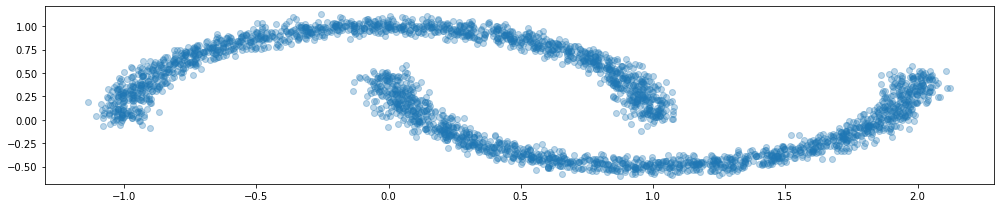

In [6]:
from sklearn.datasets import make_moons
data = make_moons(3000, noise=0.05)[0].astype(np.float32)
nn.plot_distribution_2D(samples=data, figsize=figsize)

* We use `float32` numbers for easier interplay with tensorflow

## Training

**Now, we need to train a Real NVP model**

* We will use the whole dataset (this is just a simple test)
* ...But first, we need to _standardize_ it

In [7]:
data_s = (data - data.mean(axis=0)) / data.std(axis=0)

**Standardization is very important when using Real NVPs**

* This is true for Neural Networks in general, for the usual reasons
* But even more in this case, since _the distribution for $z$ is standardized_
  - Standardizing the data makes it easier to learn a mapping

## Training

**Next we can perform training, as usual in keras**

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
model = nn.RealNVP(input_shape=2, num_coupling=10, units_coupling=32, depth_coupling=2, reg_coupling=0.01)
model.compile(optimizer='Adam')
cb = [EarlyStopping(monitor='loss', patience=40, min_delta=0.0001, restore_best_weights=True)]
history = model.fit(data_s, batch_size=256, epochs=200, verbose=1, callbacks=cb)

Epoch 1/200
12/12 [==============================] - 4s 4ms/step - loss: 2.9582
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 2.7342
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 2.5690
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 2.5072
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 2.4623
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 2.4218
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 2.3766
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 2.3357
Epoch 9/200
12/12 [==============================] - 0s 4ms/step - loss: 2.2893
Epoch 10/200
12/12 [==============================] - 0s 4ms/step - loss: 2.2384
Epoch 11/200
12/12 [==============================] - 0s 4ms/step - loss: 2.1972
Epoch 12/200
12/12 [==============================] - 0s 4ms/step - loss: 2.1474
Epoch 13/200
12/12 [=================

12/12 [==============================] - 0s 4ms/step - loss: 1.2937
Epoch 103/200
12/12 [==============================] - 0s 5ms/step - loss: 1.3117
Epoch 104/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2813
Epoch 105/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2606
Epoch 106/200
12/12 [==============================] - 0s 5ms/step - loss: 1.3260
Epoch 107/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2983
Epoch 108/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2689
Epoch 109/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2598
Epoch 110/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2481
Epoch 111/200
12/12 [==============================] - 0s 5ms/step - loss: 1.2718
Epoch 112/200
12/12 [==============================] - 0s 6ms/step - loss: 1.3031
Epoch 113/200
12/12 [==============================] - 0s 4ms/step - loss: 1.3096
Epoch 114/200
12/12 [=========

## Training

**As usual with NNs, choosing the right architecture can be complicated**

```python
model = RealNVP(input_shape=2, num_coupling=16, units_coupling=32, depth_coupling=2, reg_coupling=0.01)
```

* We went for a relatively deep model (10 affine coupling)
* Each coupling has also a good degree of non-linearity (2 hidden layers)
* We used a small degree of L2 regularization to stabilize the training process

**We also use relatively _large batch size_**

```python
history = model.fit(data_s, batch_size=256, epochs=200, verbose=2, callbacks=cb)
```

* Large batch sizes are usually a good choice with density estimation approaches
* Batches should be ideally be representative of the distribution

## Training

**Let's see the evolution of the training loss over time**

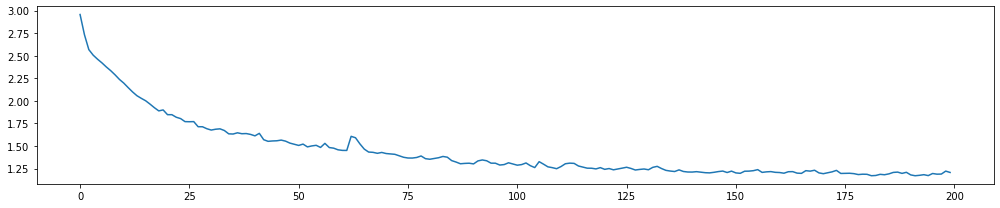

In [9]:
nn.plot_training_history(history, figsize=figsize)

## Latent Space Representation

**We can obtain the latent space representation by calling the trained model**

This will trigger the `call` method with default parameters (i.e. `training=True`)

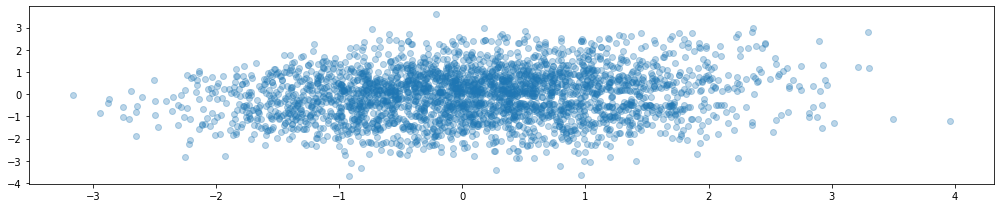

In [10]:
z, _ = model(data_s)
nn.plot_distribution_2D(samples=z, figsize=figsize)

## Density Estimation

**We can estimate the density of any data point**

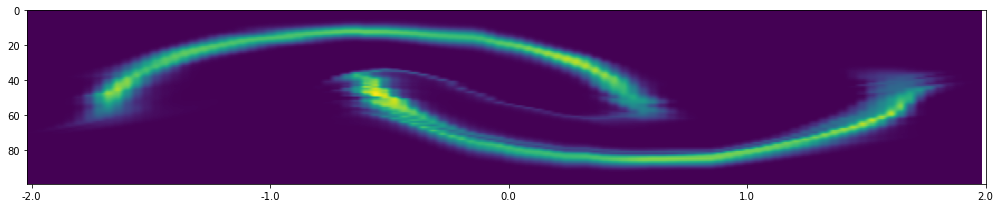

In [11]:
nn.plot_distribution_2D(estimator=model, xr=np.linspace(-2, 2, 100, dtype=np.float32),
                                         yr=np.linspace(-2, 2, 100, dtype=np.float32), figsize=figsize)

* A good approximation! With a strange low-density connection between the moons

## Data Generation

**We can also generate data, by sampling from $p_z$ and then calling `predict`**

This will trigger the `call` method with `training=False`

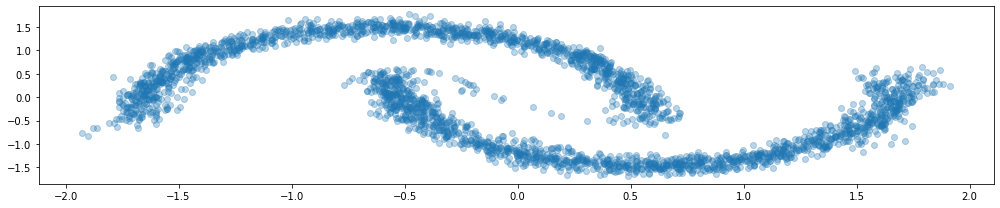

In [12]:
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)
nn.plot_distribution_2D(samples=x, figsize=figsize)

## Data Generation

**We can also plot the mapping for selected data points...**

...Which gives and intuition of how the transformation works

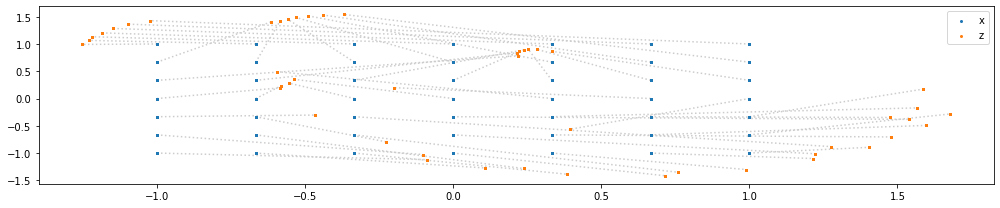

In [13]:
nn.plot_rnvp_transformation(model, figsize=figsize)

# RNVP  for Anomaly Detection

## RNVP for Anomaly Detection

**RNVPs can be used for anomaly detection like any other density estimator**

First, we build and compile the model (for the HPC data)

In [14]:
input_shape = len(hpc_in)
hpc_rnvp = nn.RealNVP(input_shape=input_shape,
                num_coupling=6, units_coupling=32, depth_coupling=1, reg_coupling=0.01)
hpc_rnvp.compile(optimizer='Adam')

We chose a _simpler_ architecture this time

* With RNVP, dealing with higher dimensional data has actually some advantage
* In particular, we have richer input for the $s$ and $t$ functions
  - In the "moons" dataset, $s$ and $t$ had 2/2 = 1 input feature
  - Now we have 159/2 = 79--80 features

## RNVP for Anomaly Detection

**Then we perform training as usual**

In [15]:
X = trdata[hpc_in].astype(np.float32).values
cb = [EarlyStopping(monitor='loss', patience=10, min_delta=0.001, restore_best_weights=True)]
history = hpc_rnvp.fit(X, batch_size=256, epochs=100, verbose=1, callbacks=cb)

Epoch 1/100
12/12 [==============================] - 2s 7ms/step - loss: 719.0934
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 905.2411
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 412.6078
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 1169.5496
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 754.5610
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 678.0566
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 434.5121
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 365.8380
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 264.4407
Epoch 10/100
12/12 [==============================] - 0s 7ms/step - loss: 195.1885
Epoch 11/100
12/12 [==============================] - 0s 6ms/step - loss: 151.8016
Epoch 12/100
12/12 [==============================] - 0s 7ms/step - loss: 123.2256
Epoch 13/100

12/12 [==============================] - 0s 6ms/step - loss: -166.6348
Epoch 100/100
12/12 [==============================] - 0s 6ms/step - loss: -167.3380


## RNVP for Anomaly Detection

**Here is the loss evolution over time**

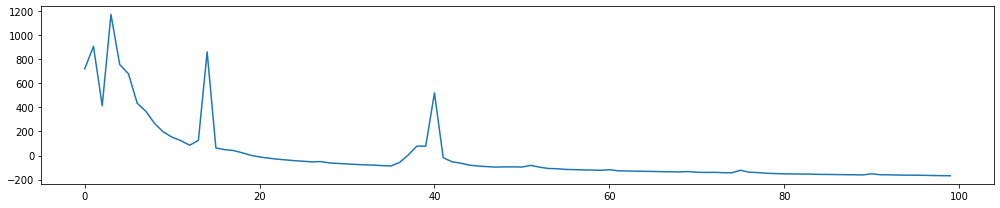

In [16]:
nn.plot_training_history(history, figsize=figsize)

## RNVP for Anomaly Detection

**Then we can generate a signal as usual**

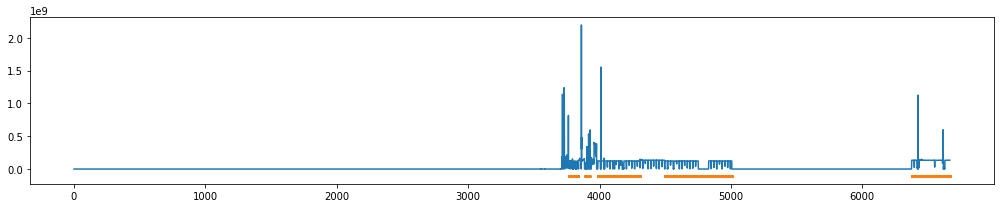

In [17]:
X = hpcs[hpc_in].astype(np.float32).values
signal_hpc = pd.Series(index=hpcs.index, data=-hpc_rnvp.score_samples(X))
nn.plot_signal(signal_hpc, hpc_labels, figsize=figsize)

* The signal is very similar to that of KDE (not a surprise)

## RNVP for Anomaly Detection

**Finally, we can tune the threshold**

In [18]:
th_range = np.linspace(1e5, 1.5e6, 100)
thr, val_cost = nn.opt_threshold(signal_hpc[tr_end:val_end],
                                        valdata['anomaly'],
                                        th_range, cmodel)
print(f'Best threshold: {thr:.3f}')
tr_cost = cmodel.cost(signal_hpc[:tr_end], hpcs['anomaly'][:tr_end], thr)
print(f'Cost on the training set: {tr_cost}')
print(f'Cost on the validation set: {val_cost}')
ts_cost = cmodel.cost(signal_hpc[val_end:], hpcs['anomaly'][val_end:], thr)
print(f'Cost on the test set: {ts_cost}')

Best threshold: 1217171.717
Cost on the training set: 0
Cost on the validation set: 269
Cost on the test set: 265


* Once again, the performance is on par with KDE
* ...But we have better support for high-dimensional data!